In [21]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchvision

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# U-NET Implementation

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_op(x)

In [5]:
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)

        return down, p

In [6]:
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1, x2], 1)
        return self.conv(x)

In [7]:

class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        self.bottle_neck = DoubleConv(512, 1024)

        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)
        
        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        down_1, p1 = self.down_convolution_1(x)
        down_2, p2 = self.down_convolution_2(p1)
        down_3, p3 = self.down_convolution_3(p2)
        down_4, p4 = self.down_convolution_4(p3)

        b = self.bottle_neck(p4)

        #Implementation of skip connections
        up_1 = self.up_convolution_1(b, down_4)
        up_2 = self.up_convolution_2(up_1, down_3)
        up_3 = self.up_convolution_3(up_2, down_2)
        up_4 = self.up_convolution_4(up_3, down_1)

        out = self.out(up_4)
        return out

In [8]:
#Create random test image
test = torch.randn(1,3,512,512)
test.shape

torch.Size([1, 3, 512, 512])

In [9]:
#Check if output shape is correct
model = UNet(3,10)
x = model(test)
x.shape

torch.Size([1, 10, 512, 512])

# Dataset Creation

In [10]:
import zipfile
#Extracting zipped dataset to working directory


with zipfile.ZipFile("/kaggle/input/carvana-image-masking-challenge/train.zip","r") as z:
    z.extractall("/kaggle/working/")

In [11]:
with zipfile.ZipFile("/kaggle/input/carvana-image-masking-challenge/train_masks.zip","r") as z:
    z.extractall("/kaggle/working/")

In [12]:
with zipfile.ZipFile("/kaggle/input/carvana-image-masking-challenge/test.zip","r") as z:
    z.extractall("/kaggle/working/")

In [13]:
import os

def get_unique_ids(directory):
    unique_ids = set()
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            # Extract ID from filename
            car_id = filename.split("_")[0]
            unique_ids.add(car_id)
    return list(unique_ids)

directory = "/kaggle/working/train"
unique_ids = get_unique_ids(directory)
print(len(unique_ids))


318


In [14]:
import random

def select_random_ids(unique_ids, percentage):
    num_ids_to_select = int(len(unique_ids) * (percentage))
    selected_ids = unique_ids[:num_ids_to_select]
    return selected_ids

percentage = 0.8
selected_ids = select_random_ids(unique_ids, percentage)
print(selected_ids)
print(len(selected_ids))

['f98dbe8a5ee2', 'c8d52e0ba341', 'dd47eb7ac4ee', 'e05b96cc2b0d', '03a857ce842d', 'bf9a32258ef4', '33a310ea7462', 'b98c63cd6102', '08a646be6b30', '1258cf954183', '562706000bd7', '3f8d611822bc', 'ef5567efd904', '36a3f7f77e85', 'db09fec614d2', '1b25ea8ba94d', '6cc98271f4dd', '364923a5002f', '1e6f48393e17', '245f9c9eab8a', '2990f858e939', 'ed8472086df8', '125cadcb9feb', '6d77433cc7ce', '85bc655a7523', '69915dab0755', 'fecea3036c59', '1ae8a68a40e4', 'bd8d5780ed04', '42415ff65013', '31186febd775', '858841907a4a', 'feaf59172a01', '4baf50a3d8c2', 'bf92e198d9b6', '9cc257b449d0', '3071362591f7', '4bea0766c14c', '292f59c6a347', 'c87688f6960e', '51f1cdf5f539', 'ad5a6a058944', '4fc2470c0f7b', '6bf969856536', 'd0dab700c896', '4e308ad8a254', '151c7f2d4183', '3c54e71fd2c9', 'f00905abd3d7', 'c502287be9f6', '0d53224da2b7', 'e2230d0ceb02', 'fa613ac8eac5', '8d78483ce302', '4e5ac4b9f074', '293a0fa72e5b', '28d7fb5ba432', '917f262f1608', '1ba84b81628e', 'a5fea424990e', '88bc32b9e1d9', '85cba1a00135', '634315

In [15]:
def filter_picture_names(picture_names, selected_ids, train=True):
    filtered_names = []
    for picture_name in picture_names:
        # Extract ID from picture name
        car_id = picture_name.split("_")[0]
        # Check if ID is in the selected IDs list
        if train:
            if car_id in selected_ids:
                filtered_names.append(picture_name)
        else:
            if car_id not in selected_ids:
                filtered_names.append(picture_name)
    return filtered_names

image_dir = "/kaggle/working/train"

filtered_names = filter_picture_names(os.listdir(image_dir), selected_ids,True)
print(len(filtered_names)/len(os.listdir(image_dir)))
#print(filtered_names)

0.7987421383647799


In [16]:
def split_data(image_dir, train_val_split= 0.8, train=True):
    unique_ids = get_unique_ids(image_dir)
    selected_ids = select_random_ids(unique_ids,train_val_split)
    filtered_names = filter_picture_names(os.listdir(image_dir), selected_ids, train)
    
    return filtered_names
    

In [17]:
from torch.utils.data import Dataset
import pathlib
from typing import Tuple
from PIL import Image
import os


class CarvanaDataset(Dataset):
    
    def __init__(self, image_dir, mask_dir, train_val_split=0.8, train=True, transform=None) -> None:
        
        #Create class attributes
        # Setup transforms
        super().__init__()
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = split_data(image_dir,train_val_split,train)

    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.images)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir,self.images[index].replace(".jpg","_mask.gif")) #Correct the name for mask files
        
        image = np.array(Image.open(img_path).convert("RGB")) #Coloured Images
        mask = np.array(Image.open(mask_path).convert("L"), dtype = np.float32) #Gray Scale
        mask[mask == 255.0] = 1.0 #Replace true label by 1 in order to work with sigmoid
        
        if self.transform is not None:
            augmentations = self.transform(image=image, mask= mask)
            image = augmentations["image"]
            mask = augmentations["mask"]
        
        
        
        return image, mask # return data, label

My data is not separated in train and val datasets. I have to do the separation myself. 

The separation needs to avoid data leakage. Pictures with the same car ID need to be in the same dataset.

In [18]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

IMAGE_HEIGHT = 160
IMAGE_WIDTH = 240

train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

val_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

In [19]:
train_dataset = CarvanaDataset("/kaggle/working/train","/kaggle/working/train_masks",0.8,True, transform = train_transform)

torch.Size([3, 160, 240])


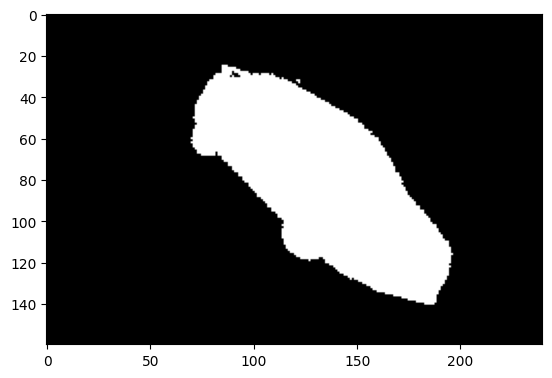

In [22]:
img,mask = train_dataset[1]
plt.imshow(mask, cmap= 'gray')
#img
print(img.shape)

In [23]:
val_dataset = CarvanaDataset("/kaggle/working/train","/kaggle/working/train_masks",0.8,False, transform= val_transform)

torch.Size([160, 240])


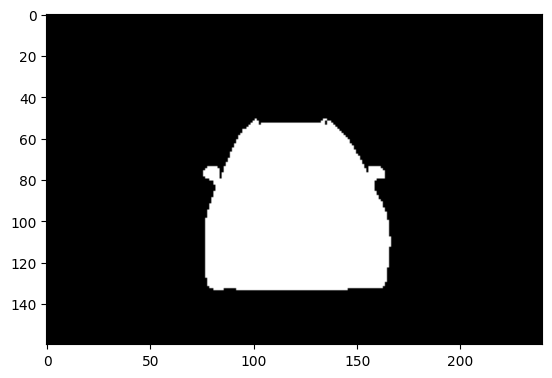

In [24]:
img_val,mask_val = val_dataset[1]
plt.imshow(mask_val, cmap= 'gray')
#img
print(mask_val.shape)

In [25]:
print(len(train_dataset))
print(len(val_dataset))

4064
1024


Datasets with split are correctly implemented!

In [26]:
#Create Dataloaders
from torch.utils.data import DataLoader

BATCH_SIZE = 16

train_dataloader = DataLoader(dataset=train_dataset, # use custom created train Dataset
                                     batch_size=BATCH_SIZE, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

val_dataloader = DataLoader(dataset=val_dataset, # use custom created test Dataset
                                    batch_size=BATCH_SIZE, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

torch.Size([16, 3, 160, 240])


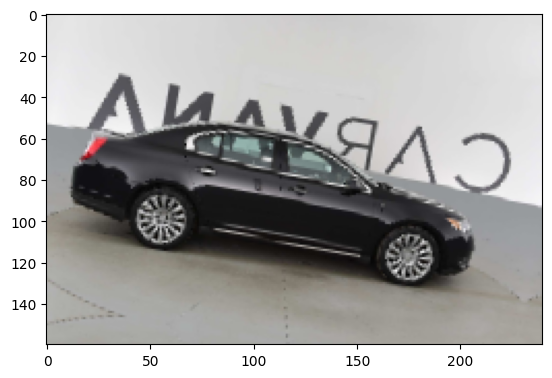

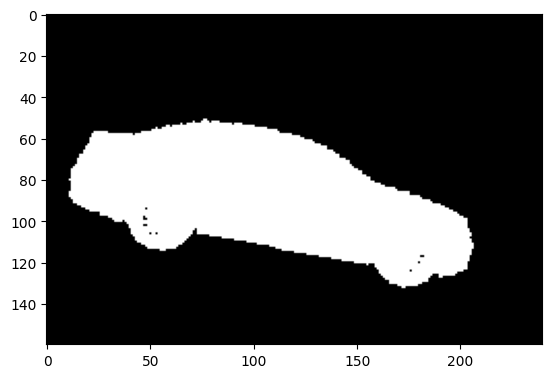

In [27]:
for idx, (X,y) in enumerate(train_dataloader):
    print(X.shape)
    plt.imshow(X[0].permute(1,2,0), cmap= 'gray')
    
    plt.figure()
    plt.imshow(y[0].unsqueeze(0).permute(1,2,0), cmap= 'gray')

    break

In [28]:
img_val,mask_val = val_dataset[2]
test_img = torch.Tensor(img_val).unsqueeze(0)
test_img.shape
mask_img = torch.Tensor(mask_val).unsqueeze(0)
model = UNet(3,1)
y = model(test_img)
y.shape

torch.Size([1, 1, 160, 240])

In [29]:
preds = torch.sigmoid(y)
preds = (preds > 0.5).float()
preds

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 1.,  ..., 0., 0., 1.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 1.,  ..., 0., 0., 1.]]]])

correct : 28779 | num_tot : 38400 | accuracy : 74.9453125


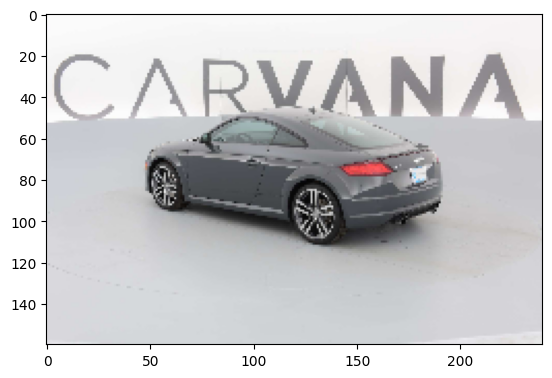

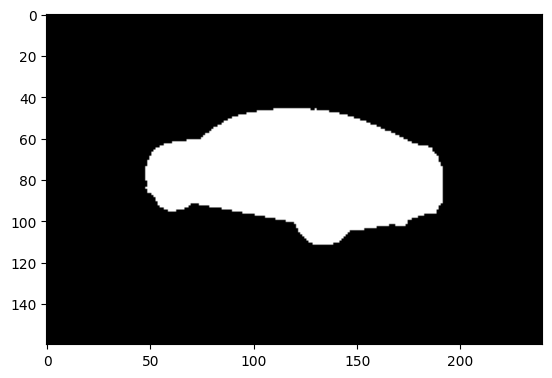

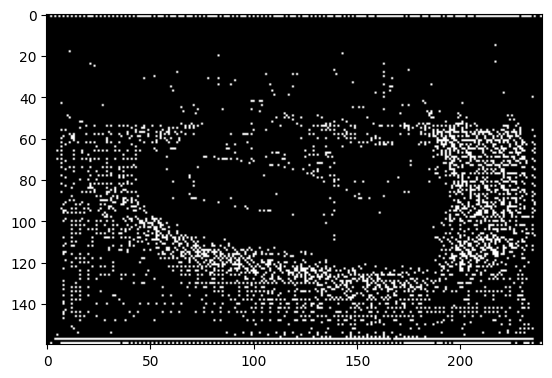

In [41]:
plt.imshow(test_img.squeeze(0).permute(1,2,0), cmap= 'gray')
    
plt.figure()
plt.imshow(mask_img.permute(1,2,0), cmap= 'gray')

plt.figure()
plt.imshow(preds.squeeze(0).permute(1,2,0).detach().numpy(), cmap= 'gray')

num_correct = (preds == mask_img).sum()
num_pixels = torch.numel(preds)
accuracy = num_correct/num_pixels*100

print(f"correct : {num_correct} | num_tot : {num_pixels} | accuracy : {accuracy}")

In [34]:
print(mask_img.shape)
print(test_img.shape)

torch.Size([1, 160, 240])
torch.Size([1, 3, 160, 240])


In [37]:
mask_img.unsqueeze(1)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])

In [71]:
batch,(X,y) = next(enumerate(val_dataloader))

y = y.float().unsqueeze(1)
        
print(X.shape)
print(y.shape)

y_pred = model(X)
print(y_pred.shape)

loss_fn = nn.BCEWithLogitsLoss()

print(y_pred[0][0][0][1])
print(y[0][0][0][1])

loss = loss_fn(y_pred[0][0][0][1],y[0][0][0][1])
print(loss)

preds = torch.sigmoid(y_pred)
preds = (preds > 0.5).float()
num_correct += (preds == y).sum()
num_pixels += torch.numel(preds)
dice_score = (2 * (preds * y).sum()) / (
    (preds + y).sum() + 1e-8
)


accuracy = (num_correct/num_pixels)*100

print(f"accuracy : {accuracy} | dice_score : {dice_score} | loss : {loss}")
print(f"num_pixels : {num_pixels}")



torch.Size([16, 3, 160, 240])
torch.Size([16, 1, 160, 240])
torch.Size([16, 1, 160, 240])
tensor(-1.2243, grad_fn=<SelectBackward0>)
tensor(0.)
tensor(0.2577, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
accuracy : 75.37451171875 | dice_score : 0.04772575572133064 | loss : 0.25770652294158936
num_pixels : 6796800


Shapes OK! --> ToTensorV2() transforms the image from HWC in CHW

In [73]:
LEARNING_RATE = 1e-4

model = UNet(in_channels=3, num_classes=1).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()


In [80]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device,
              scaler) -> Tuple[float, float]:
    
    model.train()


    train_loss = 0
    num_examples = 0
    
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    train_dice_score = 0
    train_accuracy = 0
    
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X = X.to(device)
        y = y.float().unsqueeze(1).to(device, dtype = torch.float)

        # 1. Forward pass
        #with torch.cuda.amp.autocast():
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        #loss_fn returns already the average loss in all the pixels of the batch
            
        #Calculates the Dice coefficient
        preds = torch.sigmoid(y_pred)
        preds = (preds > 0.5).float()
        num_correct = (preds == y).sum()
        num_pixels = torch.numel(preds)
        dice_score = (2 * (preds * y).sum()) / (
            (preds + y).sum() + 1e-8
        )
        train_dice_score += dice_score
        
        accuracy = (num_correct/num_pixels)*100
        train_accuracy += accuracy
            
                
        num_examples += torch.numel(y_pred) # Adapt the averaging to the actual number of labels in the batch

        # 2. Calculate  and accumulate loss
        train_loss += loss.item()
        
        #print(f"test_loss : {train_loss} | num_examples : {num_examples} | accuracy : {accuracy}")
        
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()
        #scaler.scale(loss).backward()
        #scaler.step(optimizer)
        #scaler.update()
        

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_dice_score = train_dice_score / len(dataloader)
    train_accuracy = train_accuracy / len(dataloader)
    
    return train_loss, train_dice_score, train_accuracy

In [79]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    
    # Put model in eval mode
    model.eval() 



    # Setup test loss and test accuracy values
    test_loss = 0
    num_examples = 0
    
    num_correct = 0
    num_pixels = 0
    test_dice_score = 0
    test_accuracy = 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X = X.to(device)
            y = y.float().unsqueeze(1).to(device, dtype = torch.float)

            # 1. Forward pass
            test_pred_logits = model(X)
            
            #Calculates the Dice coefficient
            preds = torch.sigmoid(test_pred_logits)
            preds = (preds > 0.5).float()
            num_correct = (preds == y).sum()
            num_pixels = torch.numel(preds)
            dice_score = (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )
            test_dice_score += dice_score
            
            
            num_examples += torch.numel(test_pred_logits) # Adapt the averaging to the actual number of labels in the batch
            accuracy = (num_correct/num_pixels)*100
            test_accuracy += accuracy


            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()


    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_dice_score = test_dice_score / len(dataloader)
    test_accuracy = test_accuracy / len(dataloader)
    
    
    return test_loss, test_dice_score, test_accuracy

In [75]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          scaler,
         save_freq = 0,
         save_name = 'Sample') -> Dict[str, List]:

    # Create empty results dictionary
    results = {"train_loss": [],
        "train_dice_score": [],
        "train_accuracy" : [],
        "test_loss": [],
        "test_dice_score": [],
        "test_accuracy" : []
    }

  # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_dice_score, train_accuracy = train_step(model=model,
                              dataloader=train_dataloader,
                              loss_fn=loss_fn,
                              optimizer=optimizer,
                              device=device,
                               scaler=scaler)
        test_loss, test_dice_score, test_accuracy = test_step(model=model,
                              dataloader=test_dataloader,
                              loss_fn=loss_fn,
                              device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.10f} | train_dice_score: {train_dice_score:.10f} | train_accuracy: {train_accuracy:.4f} |" 
          f"test_loss: {test_loss:.10f} | test_dice_score: {test_dice_score:.10f} | test_accuracy: {test_accuracy:.4f}"      
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_dice_score"].append(train_dice_score)
        results["train_accuracy"].append(train_accuracy)
        
        results["test_loss"].append(test_loss)
        results["test_dice_score"].append(test_dice_score)
        results["test_accuracy"].append(test_accuracy)
        
        if (save_freq > 0) & (epoch % save_freq == 0):
            print(f"Epoch: {epoch + 1} | Saving model")
            torch.save(obj=model.state_dict(),f=("/kaggle/working/models/" + save_name +".pth"))
            
        
    # Return the filled results at the end of the epochs
    return results

In [76]:
os.mkdir("/kaggle/working/models")

In [81]:
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results

results = train(model=model,
            train_dataloader=train_dataloader,
            test_dataloader=val_dataloader,
            optimizer=optimizer,
            loss_fn=loss_fn,
            epochs=6,
            device=device,
            scaler=scaler,
            save_freq=1,
            save_name = "Test")

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0880178773 | train_dice_score: 0.9811991453 | train_accuracy: 99.2014 |test_loss: 0.0781650302 | test_dice_score: 0.9803709388 | test_accuracy: 99.1608
Epoch: 1 | Saving model
Epoch: 2 | train_loss: 0.0674888342 | train_dice_score: 0.9820964932 | train_accuracy: 99.2412 |test_loss: 0.0664008582 | test_dice_score: 0.9791386724 | test_accuracy: 99.1219
Epoch: 2 | Saving model
Epoch: 3 | train_loss: 0.0537948858 | train_dice_score: 0.9826639295 | train_accuracy: 99.2653 |test_loss: 0.0459606058 | test_dice_score: 0.9859017134 | test_accuracy: 99.4045
Epoch: 3 | Saving model
[INFO] Total training time: 593.833 seconds


# Comparison between trained and untrained models

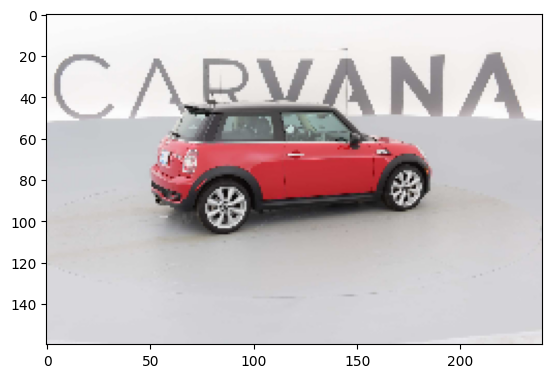

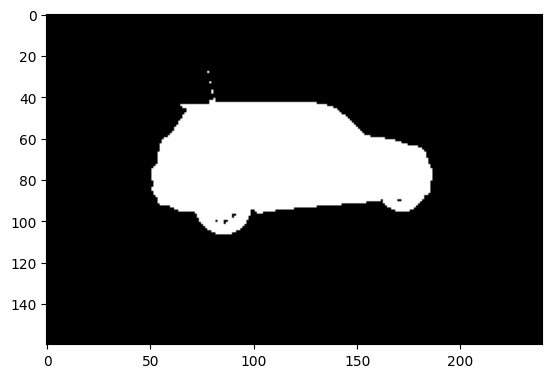

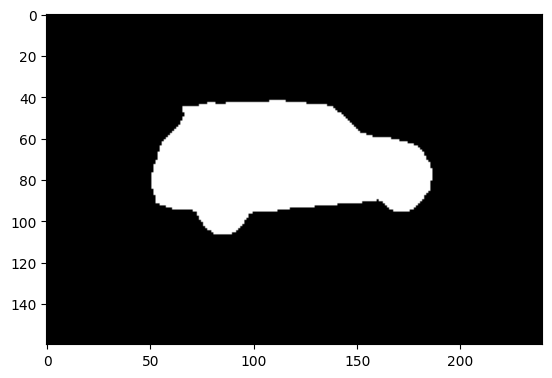

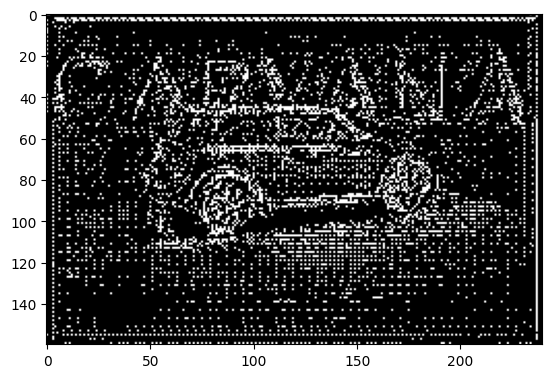

In [95]:
model_untrained = UNet(3,1).to(device)

batch,(X,y) = next(enumerate(val_dataloader))
X = X.to(device)
y = y.float().unsqueeze(1).to(device, dtype = torch.float)

preds = model(X)
preds_untrained = model_untrained(X)

preds = torch.sigmoid(preds)
preds = (preds > 0.5).float()

preds_untrained = torch.sigmoid(preds_untrained)
preds_untrained = (preds_untrained > 0.5).float()


plt.imshow(X[0].squeeze(0).permute(1,2,0).cpu(), cmap= 'gray')
    
plt.figure()
plt.imshow(y[0].permute(1,2,0).cpu(), cmap= 'gray')

plt.figure()
plt.imshow(preds[0].permute(1,2,0).cpu().detach().numpy(), cmap= 'gray')

plt.figure()
plt.imshow(preds_untrained[0].permute(1,2,0).cpu().detach().numpy(), cmap= 'gray')

#num_correct = (preds == mask_img).sum()
#num_pixels = torch.numel(preds)
#accuracy = num_correct/num_pixels*100

#print(f"correct : {num_correct} | num_tot : {num_pixels} | accuracy : {accuracy}")